trash: 100%|████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 157.51it/s]


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


C:\Users\medam\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4695 - loss: 1.4112 - val_accuracy: 0.7885 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 30657s 487s/step - accuracy: 0.7117 - loss: 0.7907 - val_accuracy: 0.8241 - val_loss: 0.5286 - learning_rate: 0.0010
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7497 - loss: 0.6952 - val_accuracy: 0.8281 - val_loss: 0.5129 - learning_rate: 0.0010
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7767 - loss: 0.6004 - val_accuracy: 0.8202 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8044 - loss: 0.5474 - val_accuracy: 0.8439 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7982 - loss: 0.5296 - val_accuracy: 0.8300 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8208 - loss: 0.4878 - val_accu

INFO:tensorflow:Assets written to: C:\Users\medam\AppData\Local\Temp\tmp2gmobf4d\assets


Saved artifact at 'C:\Users\medam\AppData\Local\Temp\tmp2gmobf4d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_173')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2697810263696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697810262736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697810263120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697810262352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697810263888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697810262928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2695323846032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2695323846416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2695323846224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2695323844688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

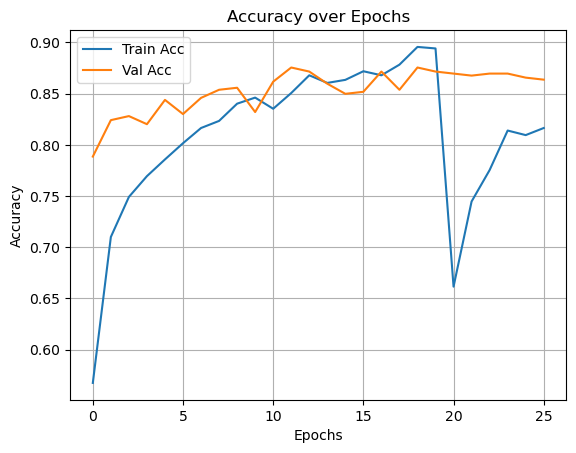

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import random

# Dataset configuration
data_dir = 'Garbage classification'
categories = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
img_size = 224  # Required for MobileNetV2
data = []

# Load and preprocess images
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for img_name in tqdm(os.listdir(path), desc=category):
        try:
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path).convert("RGB")
            img = img.resize((img_size, img_size))
            data.append([np.array(img), class_num])
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

random.shuffle(data)

X = np.array([features for features, label in data]) / 255.0
y = np.array([label for features, label in data])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=32)
val_gen = val_datagen.flow(X_test, y_test, batch_size=32)

# Load MobileNetV2 base
base_model = MobileNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

# Fine-tune: unfreeze last 50 layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# Save TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('garbage_classifier_mobilenetv2.tflite', 'wb') as f:
    f.write(tflite_model)

# Plot accuracy
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import os
import pandas as pd
from tensorflow import lite
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the model
interpreter = lite.Interpreter(model_path="C:\\Users\\medam\\Downloads\\garbage_classifier_mobilenetv2.tflite")
interpreter.allocate_tensors()

# Get model input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Categories corresponding to the indices of the output
categories = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

# Function to predict image class
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Resize image
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class and confidence
    predicted_class = np.argmax(output_data)
    confidence = output_data[0][predicted_class]

    return categories[predicted_class], confidence

# Directory of images
data_dir = 'C:\\Users\\medam\\Downloads\\Garbage classification'

# Prepare an empty list to store results
results = []

# Loop through all directories and files
for category in categories:
    folder_path = os.path.join(data_dir, category)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Predict the image
        predicted_class, confidence = predict_image(image_path)

        # Store the results in the list
        results.append({
            'Image Path': image_path,
            'Predicted Class': predicted_class,
            'Confidence': confidence
        })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Save the DataFrame to an Excel file
excel_path = 'C:\\Users\\medam\\Downloads\\garbage_classification_predictions.xlsx'
df.to_excel(excel_path, index=False)

print(f"Predictions saved to {excel_path}")


Predictions saved to C:\Users\medam\Downloads\garbage_classification_predictions.xlsx
